<a href="https://colab.research.google.com/github/MaschinenNah/MachineLearningKochbuch02_Generatoren/blob/main/03_GeneratorBilderLaden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ein Generator, der Bilddateien lädt

Wie gehabt müssen erst einmal Bilddateien in das Colab Projekt importiert werden:

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = "http://pitnoack.de/mn/generator_bilder_laden/data.zip"
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Credit: https://svaderia.github.io/articles/downloading-and-unzipping-a-zipfile/

Die Definition des Generators.

Der Einfachheit halber haben wir einen Generator konstruiert, dessen Ausgaben für x und y identisch sind. Dieser könnte zum Training eines [Autoencoders](https://de.wikipedia.org/wiki/Autoencoder) genutzt werden.

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image
import os
import random

class ImageGenerator(Sequence):

  # Der Konstruktor erwartet hier:
  # dir_ = Das Verzeichnis mit den Bilddateien
  # shape = Die shape eines Bildes
  # batch_size = Umfang eines Batches.
  def __init__(self, dir_, shape, batch_size=25):
    filenames = os.listdir(dir_)
    self.len = int(len(filenames)/batch_size)
    self.shape = shape
    self.batch_size = batch_size
    # Die Pfade zu allen Bilddateien...
    self.file_paths = [os.path.join(dir_, filename) for filename in filenames]
    # Einmal mischen....
    random.shuffle(self.file_paths)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    if index >= self.len:
      raise IndexError("list index out of range")
    else:
      # Die zum Batch gehörenden Pfade werden ermittelt:
      file_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
      # Ein leeres NumPy Array, das den Batch speichert.
      batch_x = np.empty((self.batch_size,) + (self.shape), "float32")
      for idx, file_path in enumerate(file_paths):
        img = Image.open(file_path)
        # Befüllung des Batches...
        batch_x[idx] = np.array(img).astype("float32")/255.0
      return batch_x, batch_x

Hier erzeugen wir einen Generator durch Konstruktoraufruf.

In [ ]:
train_dir = "/content/data/img_train"

# (48, 48, 3) entspricht der shape der im train_dir gespeicherten Bilder.
# Andernfalls würde es einen Fehler geben:
train_gen = ImageGenerator(train_dir, (48, 48, 3))

`train_gen[0]` ist ein Batch:

In [ ]:
batch = train_gen[0]

Ein Batch ist (wie immer) ein Tupel:

In [ ]:
type(batch)

tuple

`batch[0]` ist der x-Anteil und `batch[1]` der y-Anteil. Die shape ist entsprechend:

In [ ]:
print(batch[0].shape)
print(batch[1].shape)

(25, 48, 48, 3)
(25, 48, 48, 3)


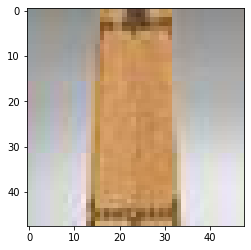

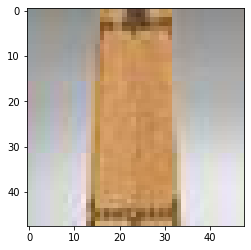

In [ ]:
from matplotlib import pyplot as plt

img_x = batch[0][0]
plt.imshow(img_x)
plt.show()

img_y = batch[1][0]
plt.imshow(img_y)
plt.show()


Das Modell ist Quatsch, wir verwenden es nur, um die Funktion des Generators zu prüfen:

In [ ]:
import numpy as np

from keras.layers import Input, Flatten, Dense, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.datasets import mnist

shape = (48, 48, 3)

input_layer = Input(shape=shape)

x = Flatten()(input_layer)

x = Dense(units=6912, activation='sigmoid')(x)

output_layer = Reshape(shape)(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 6912)              0         
_________________________________________________________________
dense (Dense)                (None, 6912)              47782656  
_________________________________________________________________
reshape (Reshape)            (None, 48, 48, 3)         0         
Total params: 47,782,656
Trainable params: 47,782,656
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = Adam(lr=0.0005)

def loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(loss=loss, optimizer=optimizer)

In [ ]:
model.fit(train_gen, epochs=10)

Epoch 1/10
100/100 [==============================] - 25s 239ms/step - loss: 0.0621
Epoch 2/10
100/100 [==============================] - 24s 237ms/step - loss: 0.0268
Epoch 3/10
100/100 [==============================] - 24s 239ms/step - loss: 0.0205
Epoch 4/10
100/100 [==============================] - 24s 239ms/step - loss: 0.0177
Epoch 5/10
100/100 [==============================] - 24s 238ms/step - loss: 0.0157
Epoch 6/10
100/100 [==============================] - 24s 236ms/step - loss: 0.0147
Epoch 7/10
100/100 [==============================] - 24s 238ms/step - loss: 0.0138
Epoch 8/10
100/100 [==============================] - 24s 241ms/step - loss: 0.0127
Epoch 9/10
100/100 [==============================] - 24s 240ms/step - loss: 0.0124
Epoch 10/10
100/100 [==============================] - 24s 239ms/step - loss: 0.0118


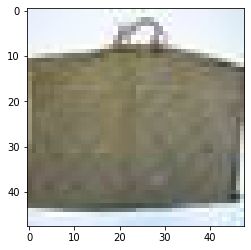

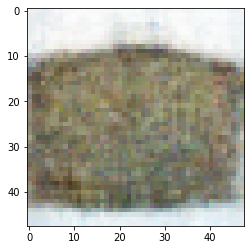

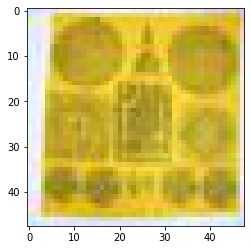

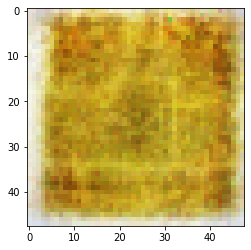

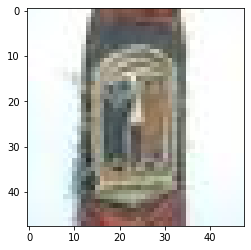

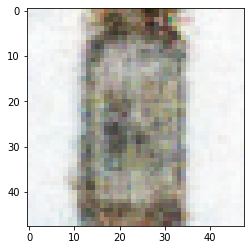

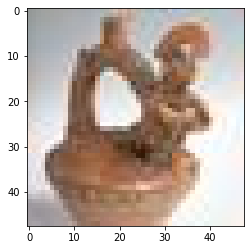

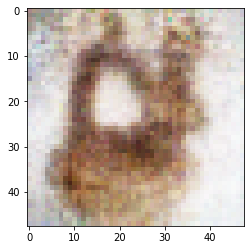

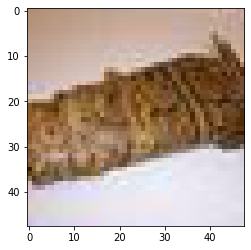

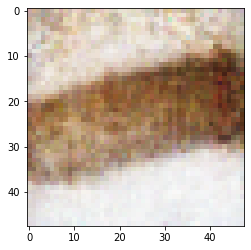

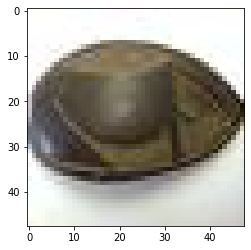

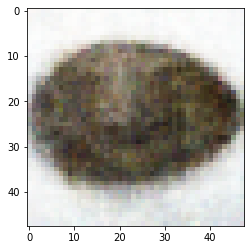

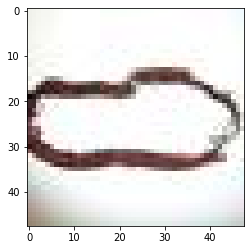

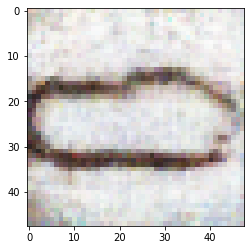

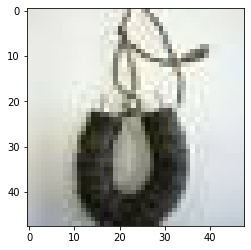

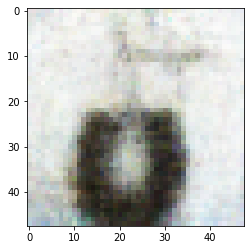

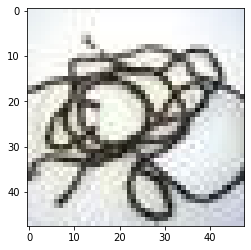

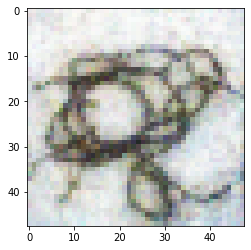

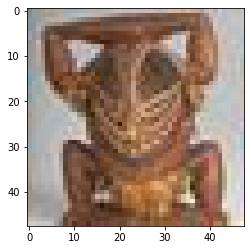

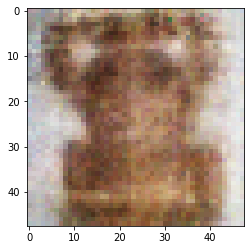

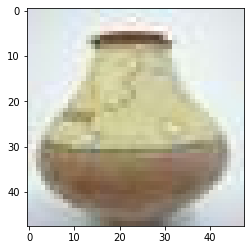

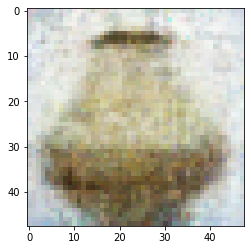

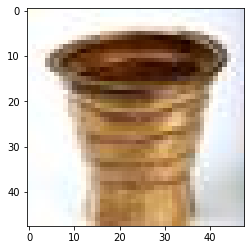

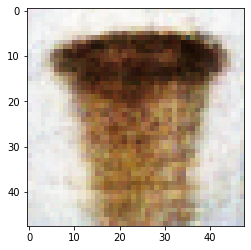

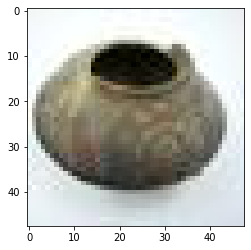

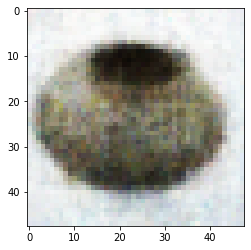

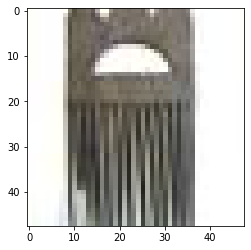

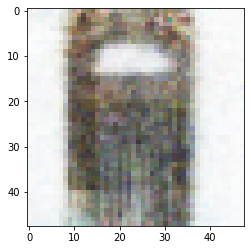

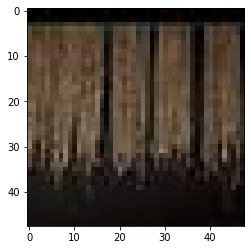

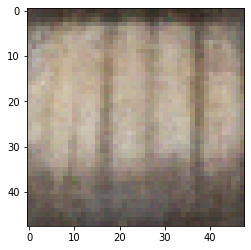

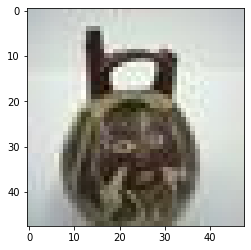

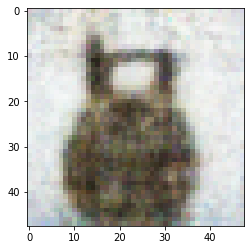

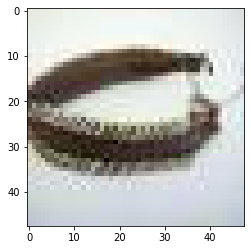

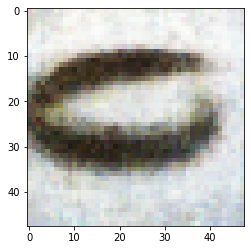

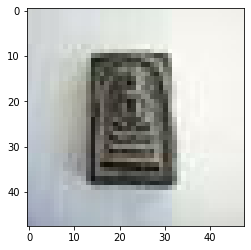

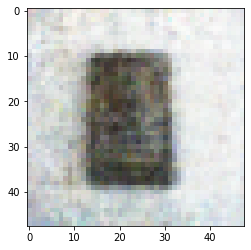

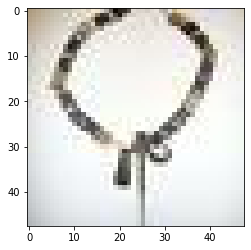

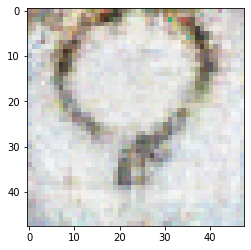

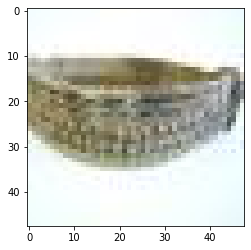

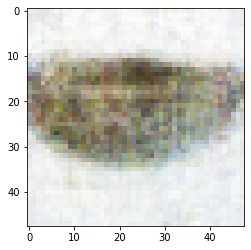

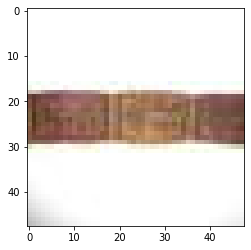

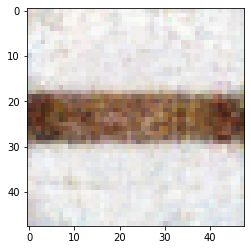

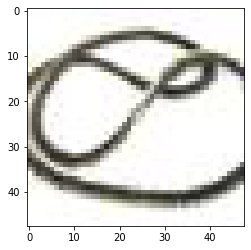

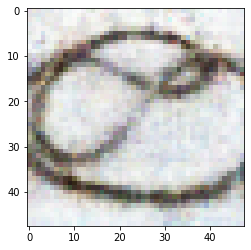

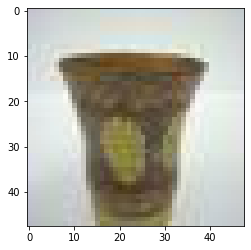

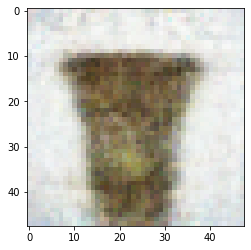

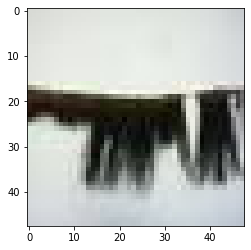

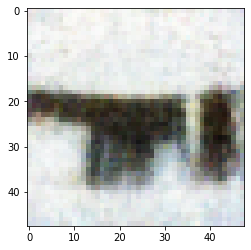

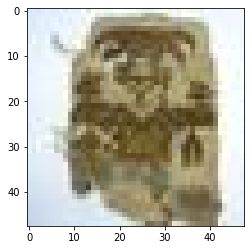

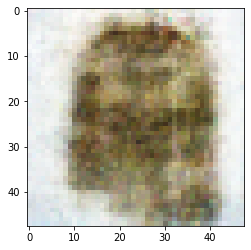

In [ ]:
x = train_gen[3][0]
y = model.predict(x)

for idx in range(x.shape[0]):
  plt.imshow(x[idx])
  plt.show()
  plt.imshow(y[idx])
  plt.show()